In [4]:
import os
import magic
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import numpy as np

import sys
repo_root = "../"
sys.path.append(repo_root)
from models import CompositeClassifier


params = {
"malconv_model_path": repo_root+'modules/sota/malconv/parameters/malconv.checkpoint',
"ember_2019_model_path": repo_root+'modules/sota/ember/parameters/ember_model.txt',
"filepath_model_path": repo_root+'modules/filepath/pretrained/1646930331-model.torch',
"filepath_bytes": repo_root+'modules/filepath/pretrained/keep_bytes-ed64-pl150-kb150-1646917941.pickle',
"emulation_model_path": repo_root+'modules/emulation/pretrained/1646990611-model.torch',
"emulation_apicalls": repo_root+'modules/emulation/pretrained/api_calls_preserved-ed96-pl150-kb600-1646926097.pickle',
"late_fusion_model": "LogisticRegression"
}

classifier = CompositeClassifier(**params)

In [12]:
TESTLIMIT = 15

adversarial_testset_path = "/data/quo.vadis/adversarial/samples_adversarial_testset/"
testset_files = os.listdir(adversarial_testset_path)[0:TESTLIMIT]

# TBD : move this to separate script and run on full adversarial folder
x_test_adv_paths = []
y_test_adv = []
for file in testset_files:
    mm = magic.from_file(adversarial_testset_path + file)
    if "PE32" in mm:
        x_test_adv_paths.append(adversarial_testset_path + file)
        y_test_adv.append(1)
    else:
        path = mm.replace("symbolic link to `", "").strip("'")
        x_test_adv_paths.append(path)
        if "clean" in path:
            y_test_adv.append(0)
        else:
            y_test_adv.append(1)

y_test_adv = np.array(y_test_adv, dtype=int)
x_test_adv = classifier.preprocess_hashlist(x_test_adv_paths)

ERROR:root: [-] Failed emulation of /data/quo.vadis/adversarial/samples_adversarial_testset/07dae107b0bcd470f058b30627f2471228d28d963e4ef4794259ac5df5da923a


ERROR:root: [-] Failed emulation of /data/quo.vadis/data/pe.dataset/PeX86Exe/clean/dece622edb3d7a2bc5ff2d694f431dbad2935b44051de371f4c9f57cf25411fa


ERROR:root: [-] Failed emulation of /data/quo.vadis/adversarial/samples_adversarial_testset/b1e1e7cbf94860163175afcfd6f552c6889a84d1e85feb57fc9c3995a1e5a240


ERROR:root: [-] Failed emulation of /data/quo.vadis/adversarial/samples_adversarial_testset/4a56c52a5d1688daf221aa1ee6e344a36d86d5f6dae972db41c890352b75e9d2


In [6]:
x_train = np.load("../composite/X-1647041985-early-fusion-vectors-train.arr")
y_train = np.load("../composite/y-1647041985-train.arr")

x_test = np.load("../composite/X-1647097165-early-fusion-vectors-test.arr")
y_test = np.load("../composite/y-1647097165-test.arr")

In [7]:
def fit(models, x_trains, y_train, save=False):
    for model in models:
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_late_fusion_model()
    return models
    
def evaluate(models, x_tests, y_test):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(x_tests[model])[:,1]
        preds = np.where(probs[model] > 0.5, 1, 0)
        print("\n", "="*6, f"{model}", "="*6)
        print(f"ROC AUC score: {roc_auc_score(y_test, probs[model])}")
        print(f"Classification report:")
        print(classification_report(y_test, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y_test.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y_test))], dtype=int)
    
    plt.figure(figsize=(14,6))
    for model in probs:
        fpr, tpr, _ = roc_curve(y_test, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        plt.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    _ = plt.legend()

## Different modules

In [14]:
modulelist = [["malconv"], ["ember"], ["filepaths"], ["emulation"], 
            ["malconv", "ember", "filepaths", "emulation"], 
            ["malconv", "ember", "emulation"]]
models = {}
x_trains = {}
x_tests = {}
x_tests_adv = {}
for modules in modulelist:
    name = "_".join(modules)
    if len(modules) == 4:
        name = "All"
    
    repo_root = "../"
    params = {
    "malconv_model_path": repo_root+'modules/sota/malconv/parameters/malconv.checkpoint',
    "ember_2019_model_path": repo_root+'modules/sota/ember/parameters/ember_model.txt',
    "filepath_model_path": repo_root+'modules/filepath/pretrained/1646930331-model.torch',
    "filepath_bytes": repo_root+'modules/filepath/pretrained/keep_bytes-ed64-pl150-kb150-1646917941.pickle',
    "emulation_model_path": repo_root+'modules/emulation/pretrained/1646990611-model.torch',
    "emulation_apicalls": repo_root+'modules/emulation/pretrained/api_calls_preserved-ed96-pl150-kb600-1646926097.pickle',
    }
    models[name] = CompositeClassifier(modules=modules, late_fusion_model="LogisticRegression", **params)
    models[name].load_late_fusion_model("/data/quo.vadis/modules/late_fustion_model/LogisticRegression.model")
    x_trains[name] = models[name].get_cropped_x(modules, x_train)
    x_tests[name] = models[name].get_cropped_x(modules, x_test)
    x_tests_adv[name] = models[name].get_cropped_x(modules, x_test_adv)


 ====== malconv ======
ROC AUC score: 0.6703612306806399
Classification report:
              precision    recall  f1-score   support

         0.0     0.1748    0.0187    0.0337      4982
         1.0     0.7228    0.9667    0.8272     13190

    accuracy                         0.7068     18172
   macro avg     0.4488    0.4927    0.4305     18172
weighted avg     0.5726    0.7068    0.6097     18172


 ====== ember ======
ROC AUC score: 0.9860326135421863
Classification report:
              precision    recall  f1-score   support

         0.0     0.8578    0.9843    0.9167      4982
         1.0     0.9937    0.9384    0.9653     13190

    accuracy                         0.9510     18172
   macro avg     0.9258    0.9614    0.9410     18172
weighted avg     0.9565    0.9510    0.9520     18172


 ====== filepaths ======
ROC AUC score: 0.9885937365417702
Classification report:
              precision    recall  f1-score   support

         0.0     0.9527    0.9267    0.9396     

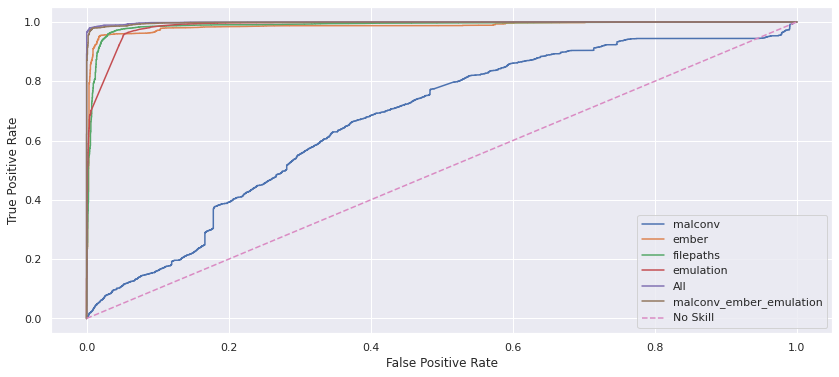

In [15]:
models = fit(models, x_trains, y_train)
evaluate(models, x_tests, y_test)


 ====== malconv ======
ROC AUC score: 0.58
Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           1     0.6429    0.9000    0.7500        10

    accuracy                         0.6000        15
   macro avg     0.3214    0.4500    0.3750        15
weighted avg     0.4286    0.6000    0.5000        15


 ====== ember ======
ROC AUC score: 1.0
Classification report:
              precision    recall  f1-score   support

           0     0.7143    1.0000    0.8333         5
           1     1.0000    0.8000    0.8889        10

    accuracy                         0.8667        15
   macro avg     0.8571    0.9000    0.8611        15
weighted avg     0.9048    0.8667    0.8704        15


 ====== filepaths ======
ROC AUC score: 1.0
Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889         5
           1     0.9091    1.0000    0

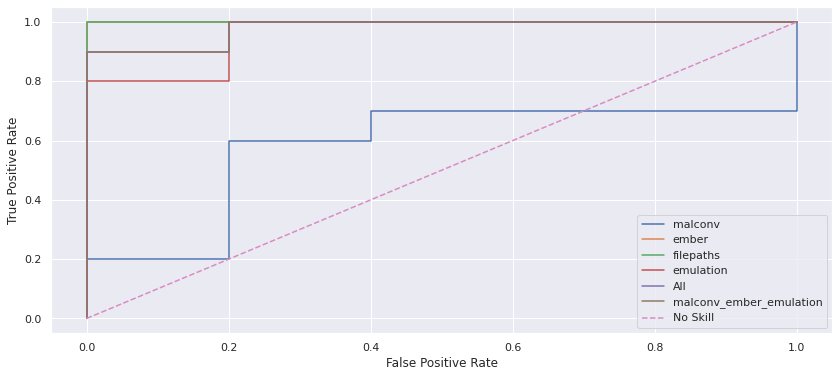

In [16]:
evaluate(models, x_tests_adv, y_test_adv)

# Compare each module separately - adversarial vs non adversarial

In [82]:
modulelist = [["malconv"], ["ember"], ["emulation"], ["malconv", "ember", "filepaths", "emulation"]]
mmodels = {}
for x in modulelist:
    key = "_".join(x)
    if key == "malconv_ember_filepaths_emulation":
        key = "All"
    mmodels[key] = models[key]

In [88]:
def evaluate_adversarial_robustness(models, x_tests, x_tests_adv, y_test, y_test_adv):
    probs = {}
    probs_adv = {}

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y_test.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y_test))], dtype=int)
    probs_adv[model] = np.array([most_common_label for _ in range(len(y_test_adv))], dtype=int)

    fig, ax = plt.subplots(2, 2, figsize=(14,12))
    ax_idx = {0: [0,0], 1: [0,1], 2: [1,0], 3:[1,1], 4:[2,0], 5:[2,1]}

    for i, model in enumerate(models):
        i1, i2 = ax_idx[i][0],ax_idx[i][1]
        probs[model] = models[model].predict_proba(x_tests[model])[:,1]
        probs_adv[model] = models[model].predict_proba(x_tests_adv[model])[:,1]
        preds = np.where(probs[model] > 0.5, 1, 0)
        preds_adv = np.where(probs_adv[model] > 0.5, 1, 0)
        
    
        fpr, tpr, _ = roc_curve(y_test, probs[model])
        fpr_adv, tpr_adv, _ = roc_curve(y_test_adv, probs_adv[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax[i1,i2].plot(fpr, tpr, linestyle=linestyle, label=model)
        ax[i1,i2].plot(fpr_adv, tpr_adv, linestyle=linestyle, label=model)
        # axis labels
        ax[i1,i2].set_xlabel('False Positive Rate')
        ax[i1,i2].set_ylabel('True Positive Rate')
        ax[i1,i2].title.set_text(model)
        _ = ax[i1,i2].legend(["regular", "adversarial"])
        # TBD - set legend position

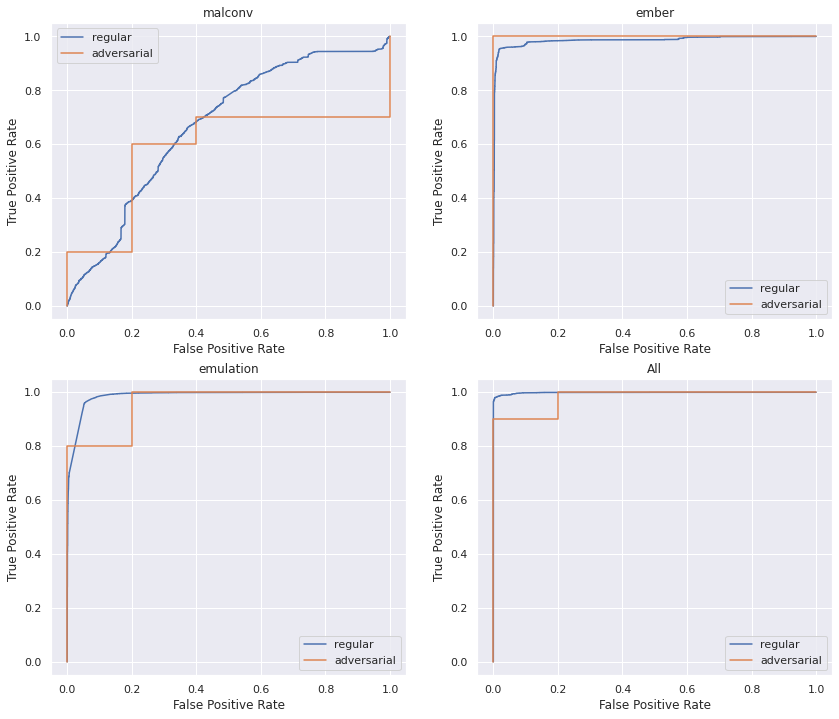

In [89]:
evaluate_adversarial_robustness(mmodels, x_tests, x_tests_adv, y_test, y_test_adv)